# Quartic Well - Illustrative Example in Section 4
Feng Chen, Daniel Kunin, Atsushi Yamamura, Surya Ganguli

In [1]:
# Load Librariesimport numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
def style_axes(ax, numyticks=5, numxticks=5, xlabel=False, ylabel=False, xlim=None, ylim=None):
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=24)
    ax.yaxis.set_major_locator(plt.MaxNLocator(numyticks))
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=24)
    ax.xaxis.set_major_locator(plt.MaxNLocator(numxticks))
    #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
#     ax.ticklabel_format(axis="x", useMathText=True)
    ax.xaxis.offsetText.set_fontsize(20)
    ax.yaxis.offsetText.set_fontsize(20)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=20)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=20)
    
    # Limits
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)

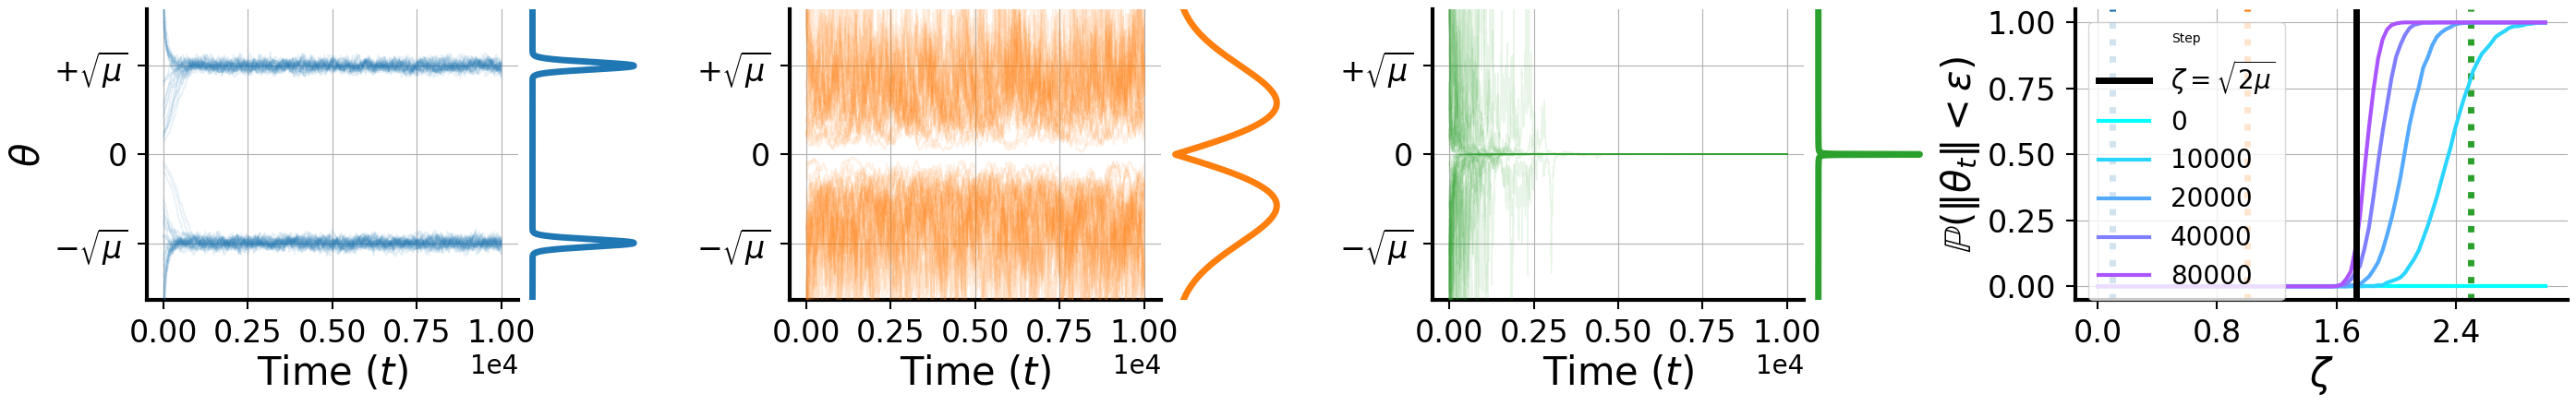

In [3]:
# Setup of experimental details
mu = 1.5
zetas = np.array([0.1, 1, 2.5])
iters, steps, T = 50, 10000, 25
eps = 1e-30
theta0 = 2 * np.random.randn(iters)
lr = T / steps

# Set up the figure and axes
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 4.5 * nrows))
cmap = plt.get_cmap("tab10")

# Iterate over axes
for i, ax in enumerate(axes):
    style_axes(ax)
    ax.grid(True)
    
    # Set x and y labels
    if i < 3:
        ax.set_xlabel("Time ($t$)", fontsize=30)
        if i==0:
            ax.set_ylabel("$\\theta$", fontsize=30)
    else:
        ax.set_xlabel("$\zeta$", fontsize=30)
        #ax.set_ylabel("Fraction of $\\theta_t$ within $\epsilon$ of $0$", fontsize=30)
        ax.set_ylabel(r'$\mathbb{P}(\|\theta_t\|<\epsilon)$', fontsize=30)

# Plot trajectories and side histograms
for i, zeta in enumerate(zetas):
    thetas = [theta0]
    for j in range(steps):
        drift = -(thetas[-1]**3 - mu * thetas[-1])
        diffusion = zeta * thetas[-1] * np.random.randn(iters)
        thetas.append(thetas[-1] + lr * drift + np.sqrt(lr) * diffusion)

    # Plot trajectories
    axes[i].plot(np.array(thetas), c=cmap(i), lw=1, alpha=0.1, zorder=10 - i)
    # axes[i].axhline(y=0, c='k', lw=2, ls='--', zorder=100)
    # axes[i].axhline(y=np.sqrt(mu), c='k', lw=2, ls='--', zorder=100)
    # axes[i].axhline(y=-np.sqrt(mu), c='k', lw=2, ls='--', zorder=100)
    axes[i].set_ylim(-2, 2)
    axes[i].set_yticks([-np.sqrt(mu), 0, np.sqrt(mu)])
    axes[i].set_yticklabels(["$-\sqrt{\mu}$", "0", "$+\sqrt{\mu}$"])
    axes[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))

    # Plot side histograms
    divider = make_axes_locatable(axes[i])
    hist_ax = divider.append_axes("right", size="30%", pad=0.1, sharey=axes[i])
    hist_ax.set_axis_off()  # Remove y-axis labels

    x = np.linspace(-2, 2, 1000)
    psi = x**2 / zeta**2 - (2 * mu / zeta**2 - 2) * np.log(np.abs(x))
    Zest = np.sum(np.exp(-psi) * (x[1] - x[0]))
    hist_ax.plot(np.exp(-psi) / Zest, x, c=cmap(i), lw=5)
    
    # Plot location of zeta in the rightmost plot
    #inf = np.min(np.array(thetas)**2, axis=0)
    inf = np.array(thetas)[-1]**2
    # axes[3].scatter(zeta, np.sum(inf < eps) / iters, color=cmap(i), s=300, zorder=100, label="$\zeta = ${}".format(zeta))

iters, steps, T = 1000, 80001, 25
theta0 = 2 * np.random.randn(iters)
# Plot probability vs. zeta
zeta_sweep = np.linspace(0, 3, 100)
prob = []
def multiprocessing_help(z):
    prob_list=[]
    thetas = [theta0]
    for j in range(steps):
        drift = -(thetas[-1]**3 - mu * thetas[-1])
        diffusion = z * thetas[-1] * np.random.randn(iters)
        thetas.append(thetas[-1] + lr * drift + np.sqrt(lr) * diffusion)
        #prob_list.append(np.sum(np.array(thetas)[-1]**2 < eps) / iters)
    #inf = np.min(np.array(thetas)**2, axis=0)
    #inf = np.array(thetas)[-1]**2
    return thetas
with Pool(32) as p:
    thetas2=p.map(multiprocessing_help, zeta_sweep)
# for z in tqdm(zeta_sweep):
#     thetas = [theta0]
#     for j in range(steps):
#         drift = -(thetas[-1]**3 - mu * thetas[-1])
#         diffusion = z * thetas[-1] * np.random.randn(iters)
#         thetas.append(thetas[-1] + lr * drift + np.sqrt(lr) * diffusion)
#     inf = np.min(np.array(thetas)**2, axis=0)
#     prob.append(np.sum(inf < eps) / iters)
for i, zeta in enumerate(zetas):
    axes[3].axvline(x=zeta, c=cmap(i), lw=5, ls=':')
axes[3].axvline(x=np.sqrt(2 * mu), c='k', lw=5, label='$\zeta = \sqrt{2\mu}$', zorder=1000)
axes[3].legend(loc='upper left', prop={'size': 20})

time_sweep = np.array([0, 10000, 20000, 40000, 80000])
cmap = plt.get_cmap("cool")
for i, t in enumerate(time_sweep):
    axes[3].plot(zeta_sweep, np.sum(np.array([th[t] for th in thetas2])**2 < eps,axis=-1) / iters, c=cmap(i/6), lw=3, label=t)
axes[3].legend(title="Step", loc='upper left', prop={'size': 20})

# Save figure
plt.tight_layout()
fig.savefig('quartic.pdf')